<a href="https://colab.research.google.com/github/amirazaiz/Colorise_B-W_images_GAN/blob/main/3_Colorizing_Pix2Pix_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating Black & White Dataset

In [ ]:
# import cv2
# import os
# import pathlib

# input_folder = "/content/drive/MyDrive/0-myComputerVisionProjects/0-0-dataset/clr_images/"
# for i, filename in enumerate(os.listdir(input_folder)):
#     img_path = os.path.join(input_folder, filename)
#     filetype = pathlib.Path(img_path).suffix
#     os.rename(input_folder + filename, input_folder + "img" + str(i+160) + filetype)

In [ ]:
# import cv2
# import os

# # Set input and output folder paths
# input_folder = '/content/drive/MyDrive/0-myComputerVisionProjects/0-0-dataset/clr_images'
# output_folder = '/content/drive/MyDrive/0-myComputerVisionProjects/0-0-dataset/bw_images'

# # Loop through images in the input folder
# for filename in os.listdir(input_folder):
#     # Check if the file is an image file
#     if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
#         # Load the image file and convert it to grayscale
#         img_path = os.path.join(input_folder, filename)
#         img = cv2.imread(img_path)
#         gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #cv2.COLOR_BGR2GRAY
#         # Save the grayscale image in the output folder
#         output_path = os.path.join(output_folder, filename)
#         # print(output_path)
#         if not cv2.imwrite(output_path, gray_img):
#           raise Exception("Could not write image")

# Importing the libraries

In [ ]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from numpy.random import randn,randint
from numpy import zeros,ones,expand_dims

In [ ]:
from keras.layers import Input,Dense,Reshape,Flatten,BatchNormalization,LeakyReLU,Conv2D,Dropout,Conv2DTranspose,Embedding,Concatenate,Activation
from keras.models import Model
from keras.optimizers import Adam

In [ ]:
from tensorflow.keras.utils import plot_model
from keras.initializers import RandomNormal

# GAN Architecture

# Discriminator :
Patch GAN
C64-C128-C256-C512
After the last layer a convolution is applied to map to a 1-dimensional output followed by a Sigmoid function.

In [ ]:
height, width , n_channels =256 ,256,3

In [ ]:
def define_discriminator(image_shape=(height, width, n_channels)):

  # weight initialization
  init = RandomNormal(stddev=0.02)

  # the two input images
  in_src_image = Input(shape=image_shape) #image_shape
  in_target_image = Input(shape=image_shape) #image_shape

  # concatentenate the two input images
  merged = Concatenate()([in_src_image,in_target_image])

  # PatchGAN architecture

  d =Conv2D(64,(4,4), strides=(2,2), padding="same",kernel_initializer=init)(merged)
  d = LeakyReLU(alpha=0.2)(d)

  d =Conv2D(128,(4,4), strides=(2,2), padding="same",kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d =Conv2D(256,(4,4), strides=(2,2), padding="same",kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d =Conv2D(512,(4,4), strides=(2,2), padding="same",kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  # Patch output
  d = Conv2D(1,(4,4),padding="same",kernel_initializer=init)(d)
  patch_out = Activation("sigmoid")(d)

  model = Model([in_src_image,in_target_image],patch_out)

  opt = Adam(lr=0.0002,beta_1=0.5)
  model.compile(optimizer=opt,loss="binary_crossentropy",metrics=['accuracy'],loss_weights=[0.5])

  return model

In [ ]:
d = define_discriminator()
plot_model(d, to_file='d_model.png', show_shapes=True)

# Encoder

In [ ]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
  init = RandomNormal(stddev=0.02)
  g = Conv2D(n_filters, (4,4), strides=(2,2),padding="same",kernel_initializer=init)(layer_in)
  if batchnorm:
    g = BatchNormalization()(g,training=True)
  g = LeakyReLU(alpha=0.2)(g)

  return g

# Decoder

In [ ]:
def define_decoder_block(layer_in,skip_in, n_filters, dropout=True):
  init =  RandomNormal(stddev=0.02)
  g = Conv2DTranspose(n_filters,(4,4),strides=(2,2),padding="same", kernel_initializer=init)(layer_in)
  g = BatchNormalization()(g,training=True)
  if dropout:
    g = Dropout(0.5)(g,training=True)
  g = Concatenate()([g,skip_in])
  g = Activation('relu')(g)

  return g


# Generator

 U_net:
 encoder: C64-C128-C256-C512-C512-C512-C512-C512
 decoder: CD512-CD512-CD512-C512-C256-C128-C64

In [ ]:
height, width , n_channels =256 ,256,3

In [ ]:
def define_generator(image_shape=(height, width, n_channels)):
  init = RandomNormal(stddev=0.02)

  in_image = Input(shape=image_shape)
  # encoder model C64-C128-C256-C512-C512-C512-C512-C512
  e1 = define_encoder_block(in_image,64,batchnorm=False)
  e2 = define_encoder_block(e1, 128)
  e3 = define_encoder_block(e2, 256)
  e4 = define_encoder_block(e3, 512)
  e5 = define_encoder_block(e4, 512)
  e6 = define_encoder_block(e5, 512)
  e7 = define_encoder_block(e6, 512)
  # bottleneck no batch_norm and relu
  b = Conv2D(512,(4,4),strides=(2,2),padding="same", kernel_initializer=init)(e7)
  b = Activation('relu')(b)
  # decoder CD512-CD512-CD512-C512-C256-C128-C64
  d1 = define_decoder_block(b, e7, 512)
  d2 = define_decoder_block(d1, e6, 512)
  d3 = define_decoder_block(d2, e5, 512)
  d4 = define_decoder_block(d3, e4, 512, dropout=False)
  d5 = define_decoder_block(d4, e3, 256, dropout=False)
  d6 = define_decoder_block(d5, e2, 128, dropout=False)
  d7 = define_decoder_block(d6, e1, 64, dropout=False)

  # output
  g = Conv2DTranspose(3 ,(4,4),strides=(2,2),padding="same",kernel_initializer=init)(d7) #outputs 3=colored image
  out_image = Activation('tanh')(g)

  model = Model(in_image, out_image)
  return model


In [ ]:
g = define_generator()
plot_model(g, to_file='g_model.png', show_shapes=True)

# GAN

In [ ]:
height, width , n_channels =256 ,256,3

In [ ]:
def define_gan(g_model, d_model, image_shape=(height,width,n_channels)):
  for layer in d_model.layers:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = False

  in_src = Input(shape = image_shape) #(256,256,3)
  gen_out = g_model(in_src)
  disc_out = d_model([in_src,gen_out])

  model = Model(in_src,[disc_out,gen_out])

  opt = Adam(lr=0.0002,beta_1=0.5)
  model.compile(optimizer=opt,loss=["binary_crossentropy","mae"],metrics=['accuracy'],loss_weights=[1,100])

  return model

# Useful functions for training our GAN

In [ ]:
def generate_real_samples(dataset, n_samples,patch_shape):
  trainA, trainB = dataset
  ix = randint(0,trainA.shape[0],n_samples)
  X1, X2 = trainA[ix], trainB[ix]
  y = ones((n_samples, patch_shape,patch_shape,1))

  return [X1,X2], y

In [ ]:
def generate_fake_samples(g_model,samples,patch_shape):
  X = g_model.predict(samples)
  y = zeros((len(X),patch_shape,patch_shape,1))

  return X, y

In [ ]:
def summarize_performance(step, g_model, dataset, n_samples=3):
  # select a sample of input images
  [X_realA,X_realB], _ = generate_real_samples(dataset, n_samples,1)
  # generate a batch of fake images
  X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
  # scale pixels from [-1,1] to [0,1]
  X_realA = (X_realA + 1 ) / 2.0
  X_realB = (X_realB + 1 ) / 2.0
  X_fakeB = (X_fakeB + 1 ) / 2.0

  # plot real src images
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1+i)
    plt.axis("off")
    plt.imshow(X_realA[i])
  # plot generated target images
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1+n_samples +i)
    plt.axis("off")
    plt.imshow(X_fakeB[i])
  # plot real target images
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1+n_samples*2 +i)
    plt.axis("off")
    plt.imshow(X_realB[i])
  # save plot to file
  filename1 = "plot_%06d.png" % (step+1)
  plt.savefig(filename1)
  plt.close()

  # save generator model
  filename2 = "model_%06d.h5" % (step+1)
  g_model.save(filename2)

  print('>Saved: %s and %s' % (filename1,filename2))

In [ ]:
def train(d_model,g_model,gan_model,dataset,n_epochs=100,n_batch=1):
  n_patch = d_model.output_shape[1]
  trainA, trainB = dataset
  bat_per_epo = int(len(trainA)/n_batch)
  n_steps = bat_per_epo * n_epochs

  for i in range(n_steps):
    [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
    X_fakeB , y_fake = generate_fake_samples(g_model, X_realA, n_patch)

    d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
    d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

    g_loss = gan_model.train_on_batch(X_realA, [y_real,X_realB])
    # print(i + 1)


    # print('>%d, d1[%.3f] d2[%.3f] g[%.3f] ' % (i+1,d_loss1, d_loss2, g_loss))

    print(f'{i+1}{d_loss1}{d_loss2} {g_loss}')

    if (i+1) % (bat_per_epo) ==0:
      summarize_performance(i, g_model,dataset)

# Declaring GAN

In [ ]:
# image_shape = src_images.shape[1:]
d_model = define_discriminator()
g_model = define_generator()
gan_model = define_gan(g_model, d_model)

# Loading the dataset & Preprocessing images

In [ ]:
from os import listdir
from numpy import asarray,load,vstack,savez_compressed
# from keras.preprocessing.image import  load_img
from tensorflow.keras.utils import img_to_array,load_img

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
img_width = 256
img_height = 256

clr_folder = '/content/drive/MyDrive/0-myComputerVisionProjects/0-0-dataset/clr_images'
bw_folder = '/content/drive/MyDrive/0-myComputerVisionProjects/0-0-dataset/bw_images'

In [ ]:

src_images = []
tar_images = []

# Sort the filenames in both folders
src_filenames = sorted(os.listdir(bw_folder))
tar_filenames = sorted(os.listdir(clr_folder))

# Load and process the images
for src_filename, tar_filename in zip(src_filenames, tar_filenames):
    if src_filename.endswith('.jpg') or src_filename.endswith('.png') or src_filename.endswith('.jpeg'):

        src_img_path = os.path.join(bw_folder, src_filename)
        # src_img = cv2.imread(src_img_path, cv2.IMREAD_GRAYSCALE)
        src_img = cv2.imread(src_img_path, 1)
        src_img = cv2.resize(src_img, (img_width, img_height))
        src_img_array = img_to_array(src_img)
        src_images.append(src_img_array)

        if tar_filename.endswith('.jpg') or tar_filename.endswith('.png') or tar_filename.endswith('.jpeg'):

            tar_img_path = os.path.join(clr_folder, tar_filename)
            tar_img = cv2.imread(tar_img_path)
            tar_img = cv2.cvtColor(tar_img, cv2.COLOR_BGR2RGB)

            tar_img = cv2.resize(tar_img, (img_width, img_height))
            tar_img_array = img_to_array(tar_img)
            tar_images.append(tar_img_array)

src_images = np.array(src_images, dtype=np.float32)
tar_images = np.array(tar_images, dtype=np.float32)


In [ ]:
print(src_images.shape, tar_images.shape)

(295, 256, 256, 3) (295, 256, 256, 3)


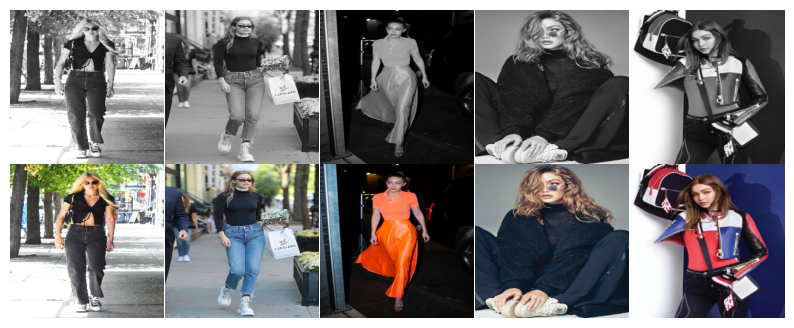

In [ ]:
n_samples = 5
plt.figure(figsize=(10, 4))

for i in range(n_samples):
  plt.subplot(2,n_samples, 1 + i)
  plt.axis('off')
  # plt.imshow(src_images[i],cmap='gray')
  plt.imshow(src_images[i].astype('uint8'))

for i in range(n_samples):
  plt.subplot(2,n_samples, 1 + i + n_samples)
  plt.axis('off')
  plt.imshow(tar_images[i].astype('uint8'))

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Preprocess input data for the gan

In [ ]:
def preprocess_data(data):
  X1 ,X2 = data[0], data[1]
  X1 = ( X1 - 127.5)/127.5
  X2 = ( X2 - 127.5)/127.5
  return [X1, X2]

In [ ]:
data = [src_images, tar_images]
dataset = preprocess_data(data)

# Training

In [ ]:
train(d_model, g_model, gan_model, dataset, n_epochs=40, n_batch=1)

# Plot generated images

In [ ]:
def plot_images(src_img, gen_img, tar_img=None):
    if tar_img is None:
        images = np.vstack((src_img, gen_img))
        # scaled_image = ((images + 1) * 127.5).astype(np.uint8)
        titles = ['Source', 'Generated']
    else:
        images = np.vstack((src_img, gen_img, tar_img))
        titles = ['Source', 'Generated', 'Real']

    images = (images + 1) / 2.0

    plt.figure(figsize=(10, 4))

    for i in range(len(images)):
        plt.subplot(1, len(images), 1 + i)
        plt.axis('off')
        plt.imshow(images[i])
        plt.title(titles[i])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()


1/1 [==============================] - 0s 35ms/step


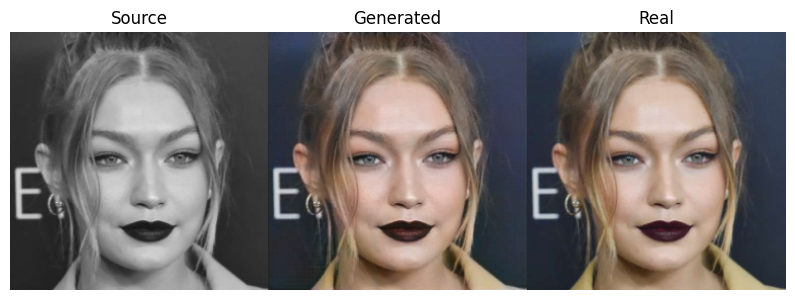

1/1 [==============================] - 0s 57ms/step


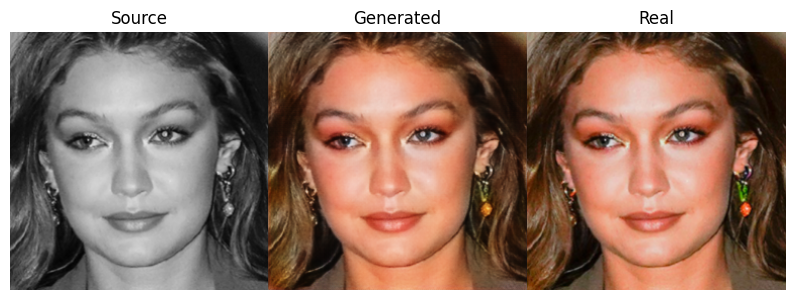

1/1 [==============================] - 0s 60ms/step


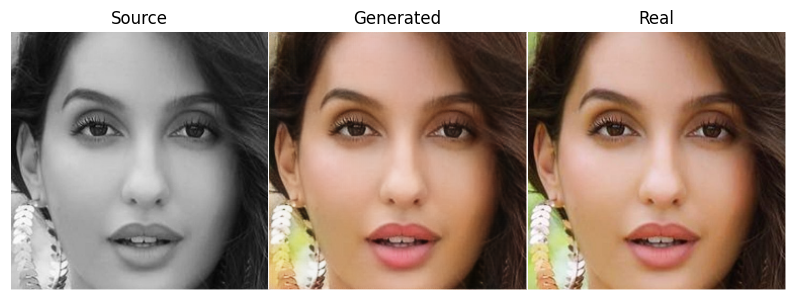

In [ ]:
[X1, X2] = dataset
for i in range(3):
  ix = randint(0, len(X1),1)
  src_img, tar_img =  X1[ix], X2[ix]
  gen_img = g_model.predict(src_img)
  plot_images(src_img, gen_img,tar_img )

1/1 [==============================] - 0s 26ms/step


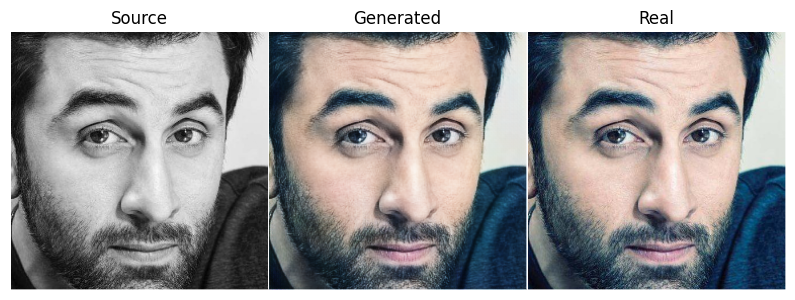

In [ ]:
[X1, X2] = dataset
ix = randint(0, len(X1),1)
src_image,tar_image = X1[ix], X2[ix]
gen_image = g_model.predict(src_image)
plot_images( src_image, gen_image, tar_image)

# Testing on unseen images

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
height,width = 256,256
def preprocess_input_img(path):
  img = cv2.imread(path)
  img = cv2.resize(img,(width, height))
  img = (img.astype('float32')/ 127.5) - 1.0
  img = np.expand_dims(img, axis=0)

  return img

In [ ]:
image1 = preprocess_input_img('g1.jpg')
image2 = preprocess_input_img('g2.jpg')
image3 = preprocess_input_img('g3.jpg')
image4 = preprocess_input_img('marilyn.png')
image5 = preprocess_input_img('bella.jpg')

In [ ]:
test_images = [image1, image2, image3, image4, image5]
test_images = np.array(test_images, dtype=np.float32)

1/1 [==============================] - 0s 31ms/step


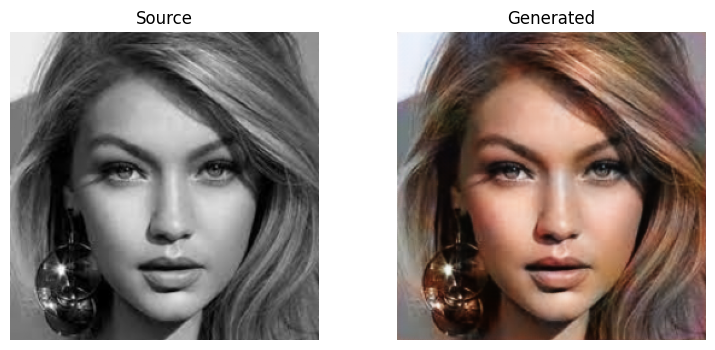

1/1 [==============================] - 0s 34ms/step


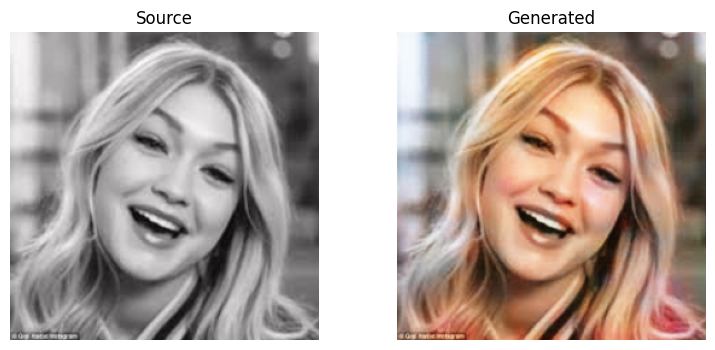

1/1 [==============================] - 0s 39ms/step


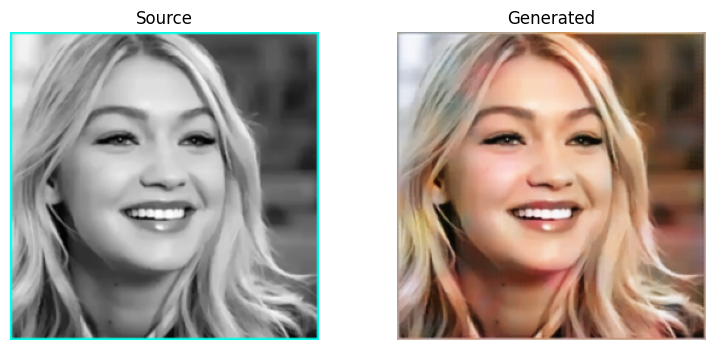

1/1 [==============================] - 0s 44ms/step


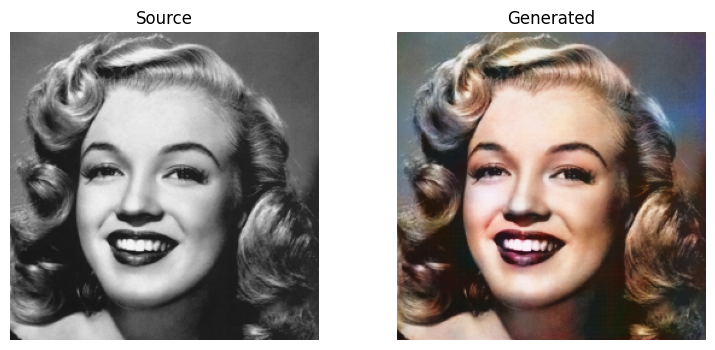

1/1 [==============================] - 0s 42ms/step


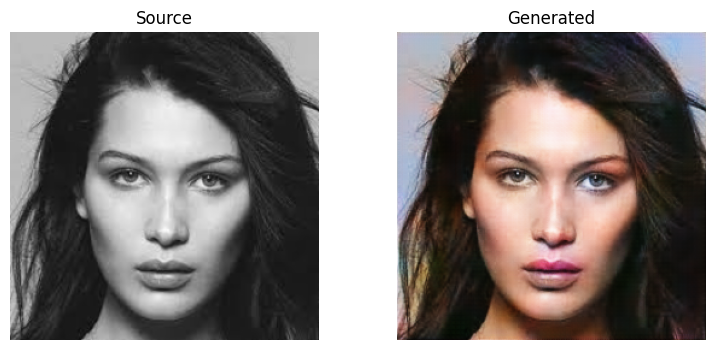

In [ ]:
for img in (test_images):
  gen_img = g_model.predict(img)
  plot_images(img, gen_img)

# Loading pretrained model

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/0-myComputerVisionProjects/0-colorize_gan_40epochs.h5')